In [1]:
from keras import metrics
from model import neural_voice_judgment_model
import idx2numpy
from os.path import join
import numpy as np
from sample_yomikomi import sample_all_data
from keras.callbacks import EarlyStopping
import tensorflow as tf
from twenty_times_more_data import twenty_times_more_data
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
import keras.backend as K
from focal_loss import focal_loss
from keras.optimizers import Adam

In [2]:
test_label_data = idx2numpy.convert_from_file(join("..","dataset","test_label.idx"))
test_image_data = idx2numpy.convert_from_file(join("..","dataset","test_image.idx"))
input_output_train_label_data = idx2numpy.convert_from_file(join("..","dataset","train_label.idx"))
input_output_train_image_data = idx2numpy.convert_from_file(join("..","dataset","train_image.idx"))
input_output_validation_label_data = idx2numpy.convert_from_file(join("..","dataset","validation_label.idx"))
input_output_validation_image_data = idx2numpy.convert_from_file(join("..","dataset","validation_image.idx"))

In [3]:
model = neural_voice_judgment_model()
model.build((None,128,128,1))
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 8)       208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                     

2022-10-15 06:37:09.040518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-15 06:37:09.040618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.compile(
    optimizer=Adam(),
    loss="binary_crossentropy",
    metrics=[
        "binary_accuracy",
        metrics.Precision(name="precision", top_k=5),
    ],
)

In [5]:
train_label_dataset = tf.data.Dataset.from_tensor_slices(input_output_train_label_data)
train_image_dataset = tf.data.Dataset.from_tensor_slices(input_output_train_image_data)
train_lump_dataset = tf.data.Dataset.zip((train_image_dataset,train_label_dataset))
callback = EarlyStopping(patience=10)
flat_map_dataset = train_lump_dataset.flat_map(twenty_times_more_data)

In [6]:
fit_data = model.fit(
    flat_map_dataset,
    epochs=100,
    steps_per_epoch=5000 * 20 / 200,
    callbacks=[callback],
    validation_data=(input_output_validation_image_data,input_output_validation_label_data),
    validation_steps=1000 / 200,
)

Epoch 1/100


2022-10-15 06:37:09.661521: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-15 06:37:10.100670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


499/500 [============================>.] - ETA: 0s - loss: 2.9813 - binary_accuracy: 0.9032 - precision: 0.1687

2022-10-15 06:37:30.384149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 21s 41ms/step - loss: 2.9765 - binary_accuracy: 0.9032 - precision: 0.1684 - val_loss: 0.5572 - val_binary_accuracy: 0.9089 - val_precision: 0.0920
Epoch 2/100
500/500 [==============================] - 20s 40ms/step - loss: 0.5092 - binary_accuracy: 0.9091 - precision: 0.1156 - val_loss: 0.4689 - val_binary_accuracy: 0.9089 - val_precision: 0.0896
Epoch 3/100
500/500 [==============================] - 20s 39ms/step - loss: 0.4390 - binary_accuracy: 0.9082 - precision: 0.1044 - val_loss: 0.4125 - val_binary_accuracy: 0.9089 - val_precision: 0.0990
Epoch 4/100
500/500 [==============================] - 20s 39ms/step - loss: 0.3943 - binary_accuracy: 0.9073 - precision: 0.0752 - val_loss: 0.3766 - val_binary_accuracy: 0.9089 - val_precision: 0.0920
Epoch 5/100
500/500 [==============================] - 20s 39ms/step - loss: 0.3671 - binary_accuracy: 0.9064 - precision: 0.0936 - val_loss: 0.3533 - val_binary_accuracy: 0.9089 - val_precision: 0.09

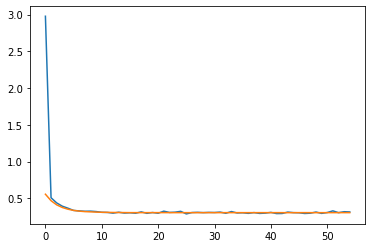

In [7]:
plt.plot(fit_data.history["loss"])
plt.plot(fit_data.history["val_loss"])

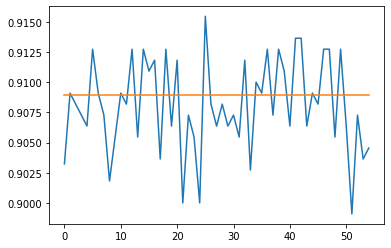

In [8]:
plt.plot(fit_data.history["binary_accuracy"])
plt.plot(fit_data.history["val_binary_accuracy"])

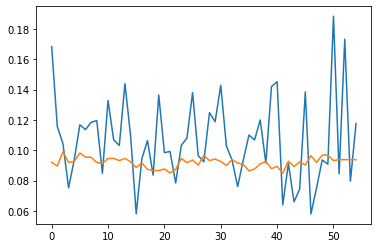

In [9]:
plt.plot(fit_data.history["precision"])
plt.plot(fit_data.history["val_precision"])

In [10]:
model.evaluate(x=test_image_data,y=test_label_data)

 1/32 [..............................] - ETA: 8s - loss: 0.3067 - binary_accuracy: 0.9091 - precision: 0.0813

2022-10-15 06:55:19.030686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step - loss: 0.3068 - binary_accuracy: 0.9089 - precision: 0.0906


[0.30680689215660095, 0.9089091420173645, 0.09060000628232956]

In [11]:
model.save(join("trained_model","seventh.tf"))

INFO:tensorflow:Assets written to: trained_model/seventh.tf/assets


INFO:tensorflow:Assets written to: trained_model/seventh.tf/assets
